<!-- Author: Moein E. Samadi <moein.samadi@rwth-aachen.de> -->

# Classification with reduced training data

In [1]:
import csv
import os
import time

import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
)

from noisecut.model.noisecut_model import NoiseCut
from noisecut.tree_structured.data_manipulator import DataManipulator

# File path initialization
input_file_path = "../data/"  # Update this to your actual path
# List of dataset names
dataset_names = ["12D_E1", "12D_E2"]

### NoiseCut implementation

In [2]:
# a dictionary for storing the results
results_NC = {}

# Loop through each file
i = 0  # loop counter
st = time.time()  # start timer
for dataset_name in dataset_names:
    i += 1
    file_path = os.path.join(input_file_path, dataset_name)

    # Read the CSV file
    data = pd.read_csv(
        file_path, delimiter="    ", header=None, skiprows=1, engine="python"
    )
    # Split the data into X and Y
    X = data.iloc[:, :-1]
    Y = data.iloc[:, -1]

    # Add noise in data labeling. Then, train and test set split.
    Training_set_size = 30
    Noise_intencity = 5
    manipulator = DataManipulator()
    x_noisy, y_noisy = manipulator.get_noisy_data(
        X, Y, percentage_noise=Noise_intencity
    )
    x_train, y_train, x_test, y_test = manipulator.split_data(
        x_noisy, y_noisy, percentage_training_data=Training_set_size
    )

    # Read the structure of the data
    with open(file_path, newline="") as csvfile:
        reader = csv.reader(csvfile, delimiter=" ")
        first_row = next(reader)  # Read the first row
    # Convert the string values to integers and store in an array
    data_structure = [int(value) for value in first_row if value.strip() != ""]

    # Fitting the hybrid model
    mdl = NoiseCut(
        n_input_each_box=data_structure
    )  # 'n_input_each_box' should fit to the generated data
    mdl.fit(x_train, y_train)

    # AUC-ROC
    y_pred_proba = mdl.predict_probability_of_being_1(x_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test.astype(int), y_pred_proba)
    print("AUC-ROC=", metrics.auc(fpr, tpr))
    print()

    # Store the values in the dictionary
    results_NC[f"dataset_{i}"] = {
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
    }

run_time = time.time() - st
print("Runtime(seconds)=", run_time)

AUC-ROC= 0.9313609296718706

AUC-ROC= 0.943799544350016

Runtime(seconds)= 2.1615850925445557


### XGBoost implementation

In [3]:
# Define the XGBoost parameter tuning function and the model
#


def set_best_params_xgb(x_train, y_train, x_test, y_test):
    tuned_parameters = [
        {
            "learning_rate": [0.01, 0.1],
            "gamma": [0, 0.2, 0.4],
            "max_depth": [4, 5, 6],
            "n_estimators": [50, 100, 200],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "early_stopping_rounds": [10, 20],
        }
    ]

    # Tuning hyperparametrs for the classifilcation accuracy
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(),
        param_grid=tuned_parameters,
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        verbose=0,
    )

    # Fit the grid search
    grid_search.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=0)

    return grid_search.best_params_


def xgb_model(x_train, y_train, x_test, y_test, best_param):
    clf = xgb.XGBClassifier(
        objective="binary:logistic",
        learning_rate=best_param["learning_rate"],
        gamma=best_param["gamma"],
        max_depth=best_param["max_depth"],
        n_estimators=best_param["n_estimators"],
        subsample=best_param["subsample"],
        colsample_bytree=best_param["colsample_bytree"],
        early_stopping_rounds=best_param["early_stopping_rounds"],
    )

    # Fitting the model with early stopping after 10 rpochs to avoid
    # overfitting
    clf = clf.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=0)
    # make predictions for test data

    ### The predicted labels ###
    return clf.predict_proba(x_test), clf.predict(x_test)

In [4]:
# a dictionary for storing the results
results_XGB = {}

# Loop through each file
i = 0  # loop counter
st = time.time()  # start timer
for dataset_name in dataset_names:
    i += 1
    file_path = os.path.join(input_file_path, dataset_name)

    # Read the CSV file
    data = pd.read_csv(
        file_path, delimiter="    ", header=None, skiprows=1, engine="python"
    )
    # Split the data into X and Y
    X = data.iloc[:, :-1]
    Y = data.iloc[:, -1]

    # Add noise in data labeling. Then, train and test set split.
    Training_set_size = 30
    Noise_intencity = 5
    manipulator = DataManipulator()
    x_noisy, y_noisy = manipulator.get_noisy_data(
        X, Y, percentage_noise=Noise_intencity
    )
    x_train, y_train, x_test, y_test = manipulator.split_data(
        x_noisy, y_noisy, percentage_training_data=Training_set_size
    )

    # Parameter tuning
    best_params_xgb = set_best_params_xgb(x_train, y_train, x_test, y_test)

    # Fitting the XGBoost model
    y_pred_proba, y_pred = xgb_model(
        x_train, y_train, x_test, y_test, best_params_xgb
    )

    # AUC-ROC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[::, 1])
    print("AUC-ROC=", metrics.auc(fpr, tpr))
    print()

    # Store the values in the dictionary
    results_XGB[f"dataset_{i}"] = {
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
    }

run_time = time.time() - st
print("Runtime(seconds)=", run_time)

AUC-ROC= 0.8073470032318754

AUC-ROC= 0.8340305232035955

Runtime(seconds)= 374.03514194488525


### Plots

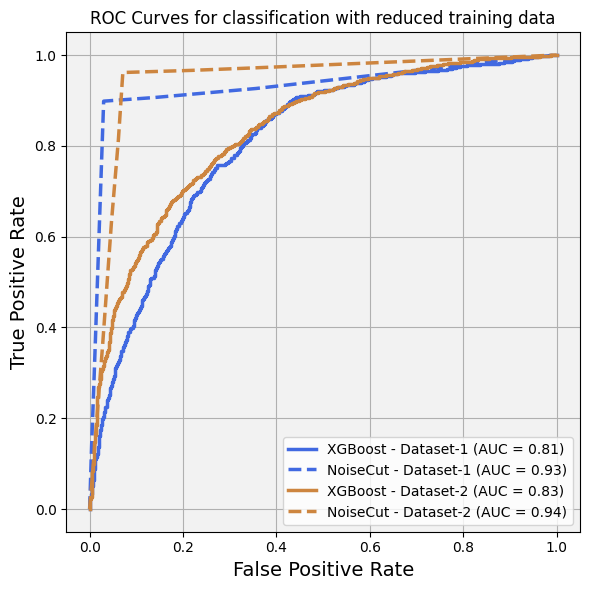

In [5]:
# Set up the figure
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_facecolor(
    (0.95, 0.95, 0.95)
)  # Adjust RGB values for a lighter gray color
ax.title.set_fontsize(16)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)

# Plot ROC curves
ax.plot(
    results_XGB[f"dataset_{1}"]["fpr"],
    results_XGB[f"dataset_{1}"]["tpr"],
    "-",
    color="royalblue",
    label="XGBoost - Dataset-1 (AUC = {:.2f})".format(
        metrics.auc(
            results_XGB[f"dataset_{1}"]["fpr"],
            results_XGB[f"dataset_{1}"]["tpr"],
        )
    ),
    linewidth=2.5,
)

ax.plot(
    results_NC[f"dataset_{1}"]["fpr"],
    results_NC[f"dataset_{1}"]["tpr"],
    "--",
    color="royalblue",
    label="NoiseCut - Dataset-1 (AUC = {:.2f})".format(
        metrics.auc(
            results_NC[f"dataset_{1}"]["fpr"],
            results_NC[f"dataset_{1}"]["tpr"],
        )
    ),
    linewidth=2.5,
)

ax.plot(
    results_XGB[f"dataset_{2}"]["fpr"],
    results_XGB[f"dataset_{2}"]["tpr"],
    "-",
    color="peru",
    label="XGBoost - Dataset-2 (AUC = {:.2f})".format(
        metrics.auc(
            results_XGB[f"dataset_{2}"]["fpr"],
            results_XGB[f"dataset_{2}"]["tpr"],
        )
    ),
    linewidth=2.5,
)

ax.plot(
    results_NC[f"dataset_{2}"]["fpr"],
    results_NC[f"dataset_{2}"]["tpr"],
    "--",
    color="peru",
    label="NoiseCut - Dataset-2 (AUC = {:.2f})".format(
        metrics.auc(
            results_NC[f"dataset_{2}"]["fpr"],
            results_NC[f"dataset_{2}"]["tpr"],
        )
    ),
    linewidth=2.5,
)

# Set title, labels, and legend
ax.set_title("ROC Curves for classification with reduced training data")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Save the figure
# fig.savefig("./multiple_roc_curve.png", dpi=300)